<a href="https://colab.research.google.com/github/stevec12/VTubers-Analysis/blob/main/CommentPrompting3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comment Prompting
This Jupyter notebook looks at training a basic transformer to provide responses to prompts based on how a YouTuber's comments would likely reply.

The YouTuber chosen is for the demo is [Ceres Fauna](!https://www.youtube.com/channel/UCO_aKKYxn4tvrqPjcTzZ6EQ), an English streamer with predominantly English comments.

The channel ID is `UCO_aKKYxn4tvrqPjcTzZ6EQ`.

# Data Extraction
The `YouTube Data API v3` can be used for this task, and an account-linked API-key can be obtained using your personal Google (Developer) Account.

In [1]:
import googleapiclient.discovery
import googleapiclient.errors

import numpy as np
import pandas as pd
!pip install xlsxwriter
import xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.2 MB/s eta 0:00:00


In [ ]:
print("Input API Key: ")
api_key = input()

Input API Key: 


In [ ]:
# Input target channel, example is @CeresFauna
channelID = 'UCO_aKKYxn4tvrqPjcTzZ6EQ'

In [ ]:
api_service_name = "youtube"
api_version = "v3"
youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=api_key)

In [ ]:
def find_uploadedID(channelID):
  request = youtube.channels().list(
      part="contentDetails",
      id=channelID
    )
  response = request.execute()

  return response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

In [ ]:
uploadedID=find_uploadedID(channelID)

In [ ]:
def find_uploaded(uploadedID):
  videoIDs = []
  request = youtube.playlistItems().list(
        part="contentDetails",
        playlistId = uploadedID,
        maxResults = 50
  )
  response = request.execute()
  for item in response['items']:
    videoIDs.append(item['contentDetails']['videoId'])
  while('nextPageToken' in response):
    request=youtube.playlistItems().list(
        part='contentDetails',
        playlistId=uploadedID,
        pageToken=response['nextPageToken'],
        maxResults=50)
    response = request.execute()
    for item in response['items']:
      videoIDs.append(item['contentDetails']['videoId'])

  return videoIDs

In [ ]:
uploaded=find_uploaded(uploadedID)

In [ ]:
def get_video_comments(videoID : str) -> pd.DataFrame:
  '''
  Given a videoID, return a pandas DataFrame with video info
  '''
  column_names = ['videoID','isTopLevel','topLevelID','commentID','authorDisplayName',
                  'likeCount','publishedAt','totalReplyCount','textOriginal']

  row_list = [] # Used to create list of dict of rows before conversion to dataframe, faster
  pageToken=''
  while(True):
    request=youtube.commentThreads().list(
        part="id,snippet,replies",
        videoId=videoID,
        pageToken=pageToken,
        maxResults=100
    )
    try:
      response=request.execute()
    except googleapiclient.errors.HttpError:
      break

    for commentThread in response['items']:
      # write top level comment
      topLevelID=commentThread['snippet']['topLevelComment']['id']
      commentID=topLevelID
      authorDisplayName=commentThread['snippet']['topLevelComment']['snippet']['authorDisplayName']
      likeCount=commentThread['snippet']['topLevelComment']['snippet']['likeCount']
      publishedAt=commentThread['snippet']['topLevelComment']['snippet']['publishedAt']
      totalReplyCount=commentThread['snippet']['totalReplyCount']
      textOriginal=commentThread['snippet']['topLevelComment']['snippet']['textOriginal']

      row_list.append({'videoID':videoID,'isTopLevel':True,'topLevelID':topLevelID,
                      'commentID':commentID,'authorDisplayName':authorDisplayName,
                      'likeCount':likeCount,'publishedAt':publishedAt,
                      'totalReplyCount':totalReplyCount,'textOriginal':textOriginal})

      # If any replies, write them as well
      if 'replies' in commentThread:
        for reply in commentThread['replies']['comments']:
          commentID=reply['id']
          authorDisplayName=reply['snippet']['authorDisplayName']
          likeCount=reply['snippet']['likeCount']
          publishedAt=reply['snippet']['publishedAt']
          textOriginal=reply['snippet']['textOriginal']

          row_list.append({'videoID':videoID,'isTopLevel':False,'topLevelID':topLevelID,
                           'commentID':commentID,'authorDisplayName':authorDisplayName,
                           'likeCount':likeCount,'publishedAt':publishedAt,
                           'totalReplyCount':totalReplyCount,'textOriginal':textOriginal})

    if 'nextPageToken' not in response:
      break
    else:
      pageToken=response['nextPageToken']

  return pd.DataFrame(row_list, columns=column_names)


In [ ]:
def uploaded_comments_to_excel(file_name, uploaded = uploaded):
  '''
  Writes all comments in the Uploaded playlist to an excel file, as a single
  worksheet.
  '''
  column_names = ['videoID','isTopLevel','topLevelID','commentID','authorDisplayName',
                  'likeCount','publishedAt','totalReplyCount','textOriginal']
  comment_df = get_video_comments(uploaded[0])

  for videoID in uploaded[1:]:
    comment_df = pd.concat([comment_df, get_video_comments(videoID)])

  comment_df.to_excel(file_name, engine='xlsxwriter', index=False)


In [ ]:
uploaded_comments_to_excel('ceres_fauna_comments_10_27_2023.xlsx')

# Preparing the Data for TensorFlow
Preparing the data using TensorFlow preprocessing layers.

Here, we use the `ceres_fauna_comments_10_27_2023.xlsx` excel file generated earlier.

In [2]:
import tensorflow as tf
!pip install -q -U "tensorflow-text==2.14.*"
import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 12.9 MB/s eta 0:00:00


In [3]:
# Load data into a pandas DataFrame
comments_df = pd.read_excel('ceres_fauna_comments_10_27_2023.xlsx')

We filter out comments that are not at least two seperate words (i.e. do not have at least one space).

This also has the effect of filtering out many purely non-English sentences.

We also shuffle the resulting tensor with `seed=12`.

In [4]:
multiple_word_indices = np.char.find(comments_df['textOriginal'].to_numpy(dtype='str'), " ") > -1
multiple_word_series = comments_df.copy().loc[multiple_word_indices]['textOriginal']

comments_tensor = tf.convert_to_tensor(multiple_word_series.to_numpy(dtype='str'), dtype='string')
comments_tensor = tf.random.shuffle(comments_tensor, seed=12)

We split the data into train, validation, and test splits.

For reasonable training times, we use a 60/10/30 split.

In [7]:
train_proportion = 0.6
valid_proportion = 0.1

Firstly, we prepare the training data to generate a vocabulary needed for the BERT tokenizer.

In [8]:
comment_ds = tf.data.Dataset.from_tensor_slices(comments_tensor)

train_split = int(np.floor(train_proportion*len(comment_ds)))
train_ds = comment_ds.take(train_split)

Generate vocabulary using [subword tokenizers](https://www.tensorflow.org/text/guide/subwords_tokenizer) tutorial.

In [6]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [5]:
vocab_file = 'vocab3.txt'

In [ ]:
%%time
vocab = bert_vocab.bert_vocab_from_dataset(
    train_ds.batch(1000).prefetch(2),
    **bert_vocab_args
)

# Save vocab to file
with open(vocab_file, 'w') as f:
  for token in vocab:
    print(token, file=f)

CPU times: user 1min 33s, sys: 270 ms, total: 1min 33s
Wall time: 1min 36s


In [9]:
# Track vocab_size
vocab_size = 0
with open(vocab_file, "rb") as f:
    vocab_size = sum(1 for _ in f)

In [10]:
tokenizer = text.BertTokenizer(vocab_file, **bert_tokenizer_params)

In [11]:
# Free unused memory before next steps
del comments_df
del comment_ds


Now we can prepare the dataset used in the Transformer model.

The data is formed as a generator to scale better by not hitting GPU ram limits.

Then tokenize, trim (to `MAX_TOKENS`), and pad the sentences, as well as form into `(prompt, teacher), label` Datasets where:
* `prompt` is a random proper subset of the sentence, beginning from the first word, bracketed by `[START]`,`[END]` tokens
* `label` is the entire trimmed sentence, followed by `[END]` token
* `teacher` is the `label` left-shifted by on token, beginning with the `[START]` token

In [12]:
MAX_TOKENS = 128
BATCH_SIZE = 64

In [13]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1,1], START)
  ends = tf.fill([count,1,1], END)

  return tf.concat([starts, ragged, ends], axis=1)

In [14]:
class commentSequence(tf.keras.utils.Sequence):
  def __init__(self, comment_tensor, batch_size=BATCH_SIZE, max_tokens=MAX_TOKENS):
    self.comment_tensor = comment_tensor
    self.batch_size = batch_size
    self.max_tokens = max_tokens

  def __len__(self):
    return int(np.ceil(self.comment_tensor.shape[0]/float(self.batch_size)))

  def __getitem__(self, idx):
    low = idx*self.batch_size
    high = min(low+self.batch_size, self.comment_tensor.shape[0])
    batch_size = high-low # gives current batch size

    tokens = tokenizer.tokenize(self.comment_tensor[low:high])[:,:self.max_tokens-1,:]

    # Create random length prompts, beginning from start of sentence
    prompt = tokens[:,:-1,:] # Shape: (batch_size, <= max_tokens-2, 1)
    token_lens = tf.cast(prompt.row_lengths()-1, dtype='float32') # Keep at least 1 token outside prompt
    prompt_lens = tf.floor(tf.random.uniform([batch_size], tf.zeros_like(token_lens), token_lens))
    prompt_lens = tf.squeeze(tf.cast(prompt_lens, dtype='int32'))

    prompt = tf.squeeze(prompt.to_tensor(shape=(batch_size, self.max_tokens-2, 1)), axis=2)
    prompt = tf.RaggedTensor.from_tensor(prompt,prompt_lens)[:,:,tf.newaxis]

    # Add [START], [END] tokens
    prompt = add_start_end(prompt)
    teacher = add_start_end(tokens)[:,:-1,:]
    label = add_start_end(tokens)[:,1:,:]

    # 0-Pad, convert to dense tensor, then form shape (batch_size, max_tokens)
    prompt = tf.squeeze(prompt.to_tensor(shape=(batch_size,self.max_tokens,1)))
    teacher = tf.squeeze(teacher.to_tensor(shape=(batch_size,self.max_tokens,1)))
    label = tf.squeeze(label.to_tensor(shape=(batch_size,self.max_tokens,1)))

    return (prompt, teacher), label


In [15]:
train_gen = commentSequence(comment_tensor = comments_tensor[:train_split])

In [16]:
valid_count = int(np.floor(valid_proportion*len(comments_tensor)))
valid_gen = commentSequence(comment_tensor = comments_tensor[train_split:train_split+valid_count])

Take a singular batch from the train data as an example.

In [17]:
(input,teacher), label = train_gen[0]
print(input.shape)
print(teacher.shape)
print(label.shape)

(64, 128)
(64, 128)
(64, 128)


In [ ]:
print(input[0])
print(teacher[0])
print(label[0])

tf.Tensor(
[   2 3513    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(128,), dtype=int64)
tf.Tensor(
[   2 3513 1009 2193   17   60 1063 4504   17 2157  990 1107 1787  992
 1017 2181 4504 1150  997 1026 2321 5835 6516 1019   15 1301   15 2400
   15 1010 1054 1194 4253   17 2439 1026 4494 1050 1663  993  992 1017
   10   61 2181 1468 1046 1123   17    0    0    0    0    0    0    0
    0    0    0

Convert tokens to vectors with a `tf.keras.layers.Embedding` layer and add positional encoding.

In [18]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [19]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [20]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [21]:
class CrossAttention(BaseAttention):
  '''def __init__(self, **kwargs):
    print('Initializing CrossAttention')
    super().__init__(self, **kwargs)'''

  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query = x,
        key = context,
        value = context,
        return_attention_scores = True
    )
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x,attn_output])
    x = self.layernorm(x)
    return x

In [22]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query = x,
        key = x,
        value = x
    )
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [23]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query = x,
        key = x,
        value = x,
        use_causal_mask = True
    )
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [24]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x,self.seq(x)])
    x = self.layer_norm(x)
    return x

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*,d_model,num_heads,dff,dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )
    self.ffn = FeedForward(d_model,dff)

  def call(self,x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [26]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size = vocab_size, d_model = d_model
    )

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)
    ]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self,x):
    # `x` is token-IDs shape: (batch_size, seq_len)
    x = self.pos_embedding(x) # Shape '(batch_size, seq_len, d_model)'.

    # Add dropout
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x # Shape `(batch_size, seq_length, d_model)`

In [27]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*,d_model,num_heads,dff,dropout_rate=0.1):
    super(DecoderLayer,self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads = num_heads,
        key_dim = d_model,
        dropout = dropout_rate
    )

    self.cross_attention = CrossAttention(
        num_heads = num_heads,
        key_dim = d_model,
        dropout = dropout_rate
    )

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x) # Shape `(batch_size, seq_len, d_model)`
    return x

In [28]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*,num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)
    ]
    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x) # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.dec_layers[i](x,context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # shape of x is (batch_size, target_seq_len, d_model)
    return x


In [29]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                           dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                           dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To support Keras model '.fit', pass all inputs as first argument
    context, x = inputs

    context = self.encoder(context) # (batch_size, context_len, d_model)

    x = self.decoder(x, context) # (batch_size, target_len, d_model)

    logits = self.final_layer(x) # (batch_size, target_len, target_vocab_size)

    try:
      # Drop keras mask, so it doesn't scale losses/metrics
      del logits._keras_mask
    except AttributeError:
      pass

    # Return final output and attention weights
    return logits

## Hyperparameters

In [30]:
num_layers = 6
d_model = 128
dff = 1024
num_heads = 10
dropout_rate = 0.1

## Testing

In [ ]:
transformer = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                          dff=dff, input_vocab_size=vocab_size, target_vocab_size=vocab_size,
                          dropout_rate=dropout_rate)

In [ ]:
output = transformer((input,teacher))
print(teacher.shape)
print(input.shape)
print(output.shape)

(64, 128)
(64, 128)
(64, 128, 7881)


In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  6547584   
                                                                 
 decoder (Decoder)           multiple                  10505088  
                                                                 
 dense_24 (Dense)            multiple                  1016649   
                                                                 
Total params: 18069321 (68.93 MB)
Trainable params: 18069321 (68.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training
Uses Adam optimizer with original [Transformer paper](https://arxiv.org/abs/1706.03762) custom learning rate scheduler.

$$lrate = d_{model}^{-0.5}*\min\left(step_{num}^{-0.5},step_{num}*warmup\_steps^{-1.5}\right)$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9,
                                     beta_2=0.98, epsilon=1e-9)

In [ ]:
# Setup padding mask for calculating loss properly
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )
  loss = loss_object(label,pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

Setup Checkpoint saving of weights after each epoch, then begin training.

In [31]:
checkpoint_path = 'checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         verbose=1)

In [ ]:
transformer.compile(loss=masked_loss, optimizer=optimizer,
                    metrics=[masked_accuracy], run_eagerly=False)

In [ ]:
transformer.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[checkpoint_callback])

Epoch 1/20
840/840 [==============================] - ETA: 0s - loss: 6.5416 - masked_accuracy: 0.1143
Epoch 1: saving model to training_3/checkpoint.ckpt
840/840 [==============================] - 654s 723ms/step - loss: 6.5416 - masked_accuracy: 0.1143 - val_loss: 4.8323 - val_masked_accuracy: 0.2466
Epoch 2/20
840/840 [==============================] - ETA: 0s - loss: 4.2009 - masked_accuracy: 0.3280
Epoch 2: saving model to training_3/checkpoint.ckpt
840/840 [==============================] - 606s 721ms/step - loss: 4.2009 - masked_accuracy: 0.3280 - val_loss: 3.4936 - val_masked_accuracy: 0.4320
Epoch 3/20
840/840 [==============================] - ETA: 0s - loss: 3.3855 - masked_accuracy: 0.4447
Epoch 3: saving model to training_3/checkpoint.ckpt
840/840 [==============================] - 607s 723ms/step - loss: 3.3855 - masked_accuracy: 0.4447 - val_loss: 3.0721 - val_masked_accuracy: 0.4901
Epoch 4/20
840/840 [==============================] - ETA: 0s - loss: 3.0422 - masked_ac

Loading model weights manually.

In [32]:
# Load weights
transformer = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                          dff=dff, input_vocab_size=vocab_size, target_vocab_size=vocab_size,
                          dropout_rate=dropout_rate)
transformer.load_weights(checkpoint_path)

# Additional Testing
Not expected to be especially different than the validation accuracy, but could be interesting regardless.

Only a fraction of the test set is used to save time.

In [ ]:
test_fraction = 0.1
test_count = tf.cast(tf.floor(len(comment_ds)*test_fraction), dtype='int64')
test_gen = commentSequence(comment_tensor = comments_tensor[train_split+valid_count:train_split+valid_count+test_count],
                           batch_size = test_count)
(test_prompt, test_teacher), test_label = test_gen[0]

In [ ]:
%%time
test_loss, test_acc = transformer.evaluate(x=(test_prompt,test_teacher), y=test_label, verbose=2)

# Run Inference
Create a model to generate comments from prompts:
* Encode prompt with `tokenizer`, trim, add `[START],[END]`, then pad - this is the encoder input
* calculate padding masks and look-ahead masks
* `decoder` outputs preds by looking at `encoder` output and own output
* Concatenate predicted token to decoder input and pass to of decoder
* Decoder predicts next token based on previous tokens it predicted

Add a `temperature` call argument that allows variability in the response
* `temperture <= 0` always gives the most likely prediction

In [33]:
class TemperatureCommentator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, temperature = 0.0, max_length=128):
    '''
    Temperature = 0 equivalent to always selecting most likely prediction
    '''
    # Add '[START]' and '[END]' tokens to input sentence
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.tokenize(sentence)[:,:MAX_TOKENS-2,:]
    sentence = tf.squeeze(add_start_end(sentence).to_tensor(shape=(1,MAX_TOKENS,1)),axis=2)
    encoder_input = sentence

    # Init output with '[START]' token
    out = self.tokenizers.tokenize(tf.constant(['']))
    start_end = add_start_end(out)[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # 'tf.TensorArray' required so dynamic-loop traced by tf.function
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      output = tf.squeeze(output, axis=1)
      predictions = self.transformer([encoder_input, output], training = False)

      # Select last token from `seq_len` dimension
      predictions = tf.squeeze(predictions[:,-1:,:], axis=0) # Shape `(batch_size, 1, vocab_size)`

      # Adjust randomness for `temperature`, with 0 (or less) offering no randomness
      predicted_id = None
      if (temperature > 0):
        predicted_id = tf.random.categorical(predictions/temperature, num_samples=1)
      else:
        predicted_id = tf.argmax(predictions, axis=-1)[tf.newaxis]

      # Concatenate `predicted_id` to output given to decoder as input
      output_array = output_array.write(i+1, predicted_id)

      if predicted_id == end:
        break

    output = tf.squeeze(tf.transpose(output_array.stack()), axis=0)
    # output shape `(1,tokens)`
    # text removes the `[START]`,`[END]` tokens
    text = tf.strings.reduce_join(self.tokenizers.detokenize(output)[0][1:-1], axis=0, separator=" ") # Shape: `()`

    tokens = self.tokenizers.detokenize(output)[0]
    # `tf.function` prevents usage of attention_wieghts calculated
    # on last iteration of loop - recalc. outside of loop
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [130]:
def print_comment(sentence, tokens, true_comment = None):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  if true_comment:
    print(f'{"True Comment":15s}: {true_comment}')

In [132]:
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")
UNK = tf.argmax(tf.constant(reserved_tokens) == "[UNK]")

def fetch_validation_sentence(validation_set_generator, tokenizer, batch_size : int = BATCH_SIZE, seed : int = None):
  if (seed == None):
    seed = np.random.randint(low = 0, high = valid_count)
  batch_index = seed%batch_size
  batch_number = int((seed - batch_index)/batch_size)
  (sentences_tokenized, _ ) = validation_set_generator[batch_number]
  sentence_tokens = sentences_tokenized[0][batch_index]
  end_index = tf.argmax(sentence_tokens == END)

  last_token = UNK
  for i in range(1,end_index-1):
    last_token = sentence_tokens[end_index-i]

    if (last_token != UNK):
      break
  last_token = tf.RaggedTensor.from_tensor(last_token[tf.newaxis][tf.newaxis])
  last_sentence_fragment = tokenizer.detokenize(last_token)[0].numpy()[0].decode("utf-8")

  true_comment = comments_tensor[train_split+seed].numpy().decode("utf-8")
  sentence_index = true_comment.rfind(last_sentence_fragment)
  sentence = true_comment[:sentence_index+len(last_sentence_fragment)]

  return (sentence, true_comment)

In [35]:
temperature_commentator = TemperatureCommentator(tokenizer, transformer)

In [ ]:
sentence = 'I miss'
output_text, output_tokens, attention_weights = temperature_commentator(tf.constant(sentence),0)
print_comment(sentence, output_text)

Input:         : I miss
Prediction     : i miss fauna . . .


In [ ]:
sentence = 'I miss'
output_text, output_tokens, attention_weights = temperature_commentator(tf.constant(sentence),1.5)
print_comment(sentence, output_text)

Input:         : I miss
Prediction     : i miss you my sap never head lit throwing vacation evidence * extinct 9 christ anyone isn ' t arm buttons dig the class immortal floor ! coconut ur drunk squeeb loved expecting a full school mother nature or shiny abilities 💚💚💚💚


In [134]:
sentence, true_comment = fetch_validation_sentence(valid_gen, tokenizer=tokenizer,seed=77)
output_text, output_tokens, attention_weights = temperature_commentator(tf.constant(sentence),0)
print_comment(sentence, output_text, true_comment)

Input:         : Thanks for the amazing stream Fauna! Was here from start to finish, the collabs were especially
Prediction     : thanks for the amazing stream fauna ! was here from start to finish , the collabs were especially fun and i hope you have a great time in japan !
True Comment   : Thanks for the amazing stream Fauna! Was here from start to finish, the collabs were especially really fun. Happy anniversary again, now time for some karaoke! 


Visualize attention:

In [135]:
from matplotlib import pyplot as plt

In [ ]:
def plot_attention_head(in_tokens, in_tokens_len, out_tokens, attention, start_focused):
  # remove automatic `[START]` token
  out_tokens = out_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention[:,:in_tokens_len])
  ax.set_xticks(range(in_tokens_len))
  ax.set_yticks(range(len(out_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(labels[:in_tokens_len], rotation=90)

  labels = [label.decode('utf-8') for label in out_tokens.numpy()]
  ax.set_yticklabels(labels)

def plot_attention_weights(sentence, out_tokens, attention_heads, start_focused = True):
  in_tokens = tokenizer.tokenize(sentence)[:MAX_TOKENS-2]
  in_tokens_len = in_tokens.row_lengths()[0].numpy()+2

  in_tokens = tf.squeeze(add_start_end(in_tokens).to_tensor(shape=(1,MAX_TOKENS,1)),axis=2)
  in_tokens = tokenizer.detokenize(in_tokens)[0]

  fig = plt.figure(figsize=(48, 24))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(3, 4, h+1)

    plot_attention_head(in_tokens, in_tokens_len, out_tokens, head, start_focused)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [224]:
def plot_attention_head(in_tokens, in_tokens_len, out_tokens, attention, start_focused):
  # remove automatic `[START]` token
  out_tokens = out_tokens[1:]

  ax = plt.gca()

  # Set x-ticks, input with/out '[START]' token depending on if we want to focus elsewhere
  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  if start_focused:
    ax.matshow(attention[:,:in_tokens_len])
    ax.set_xticks(range(in_tokens_len))
    ax.set_xticklabels(labels[:in_tokens_len], rotation=90)
  else:
    ax.matshow(attention[:,1:in_tokens_len])
    ax.set_xticks(range(in_tokens_len-1))
    ax.set_xticklabels(labels[1:in_tokens_len], rotation=90)

  # Set y-ticks
  ax.set_yticks(range(len(out_tokens)))

  labels = [label.decode('utf-8') for label in out_tokens.numpy()]
  ax.set_yticklabels(labels)

def plot_attention_weights(sentence, out_tokens, attention_heads, start_focused = True):
  in_tokens = tokenizer.tokenize(sentence)[:MAX_TOKENS-2]
  in_tokens_len = in_tokens.row_lengths()[0].numpy()+2

  in_tokens = tf.squeeze(add_start_end(in_tokens).to_tensor(shape=(1,MAX_TOKENS,1)),axis=2)
  in_tokens = tokenizer.detokenize(in_tokens)[0]

  fig = plt.figure(figsize=(48, 24))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(3, 4, h+1)

    plot_attention_head(in_tokens, in_tokens_len, out_tokens, head, start_focused)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

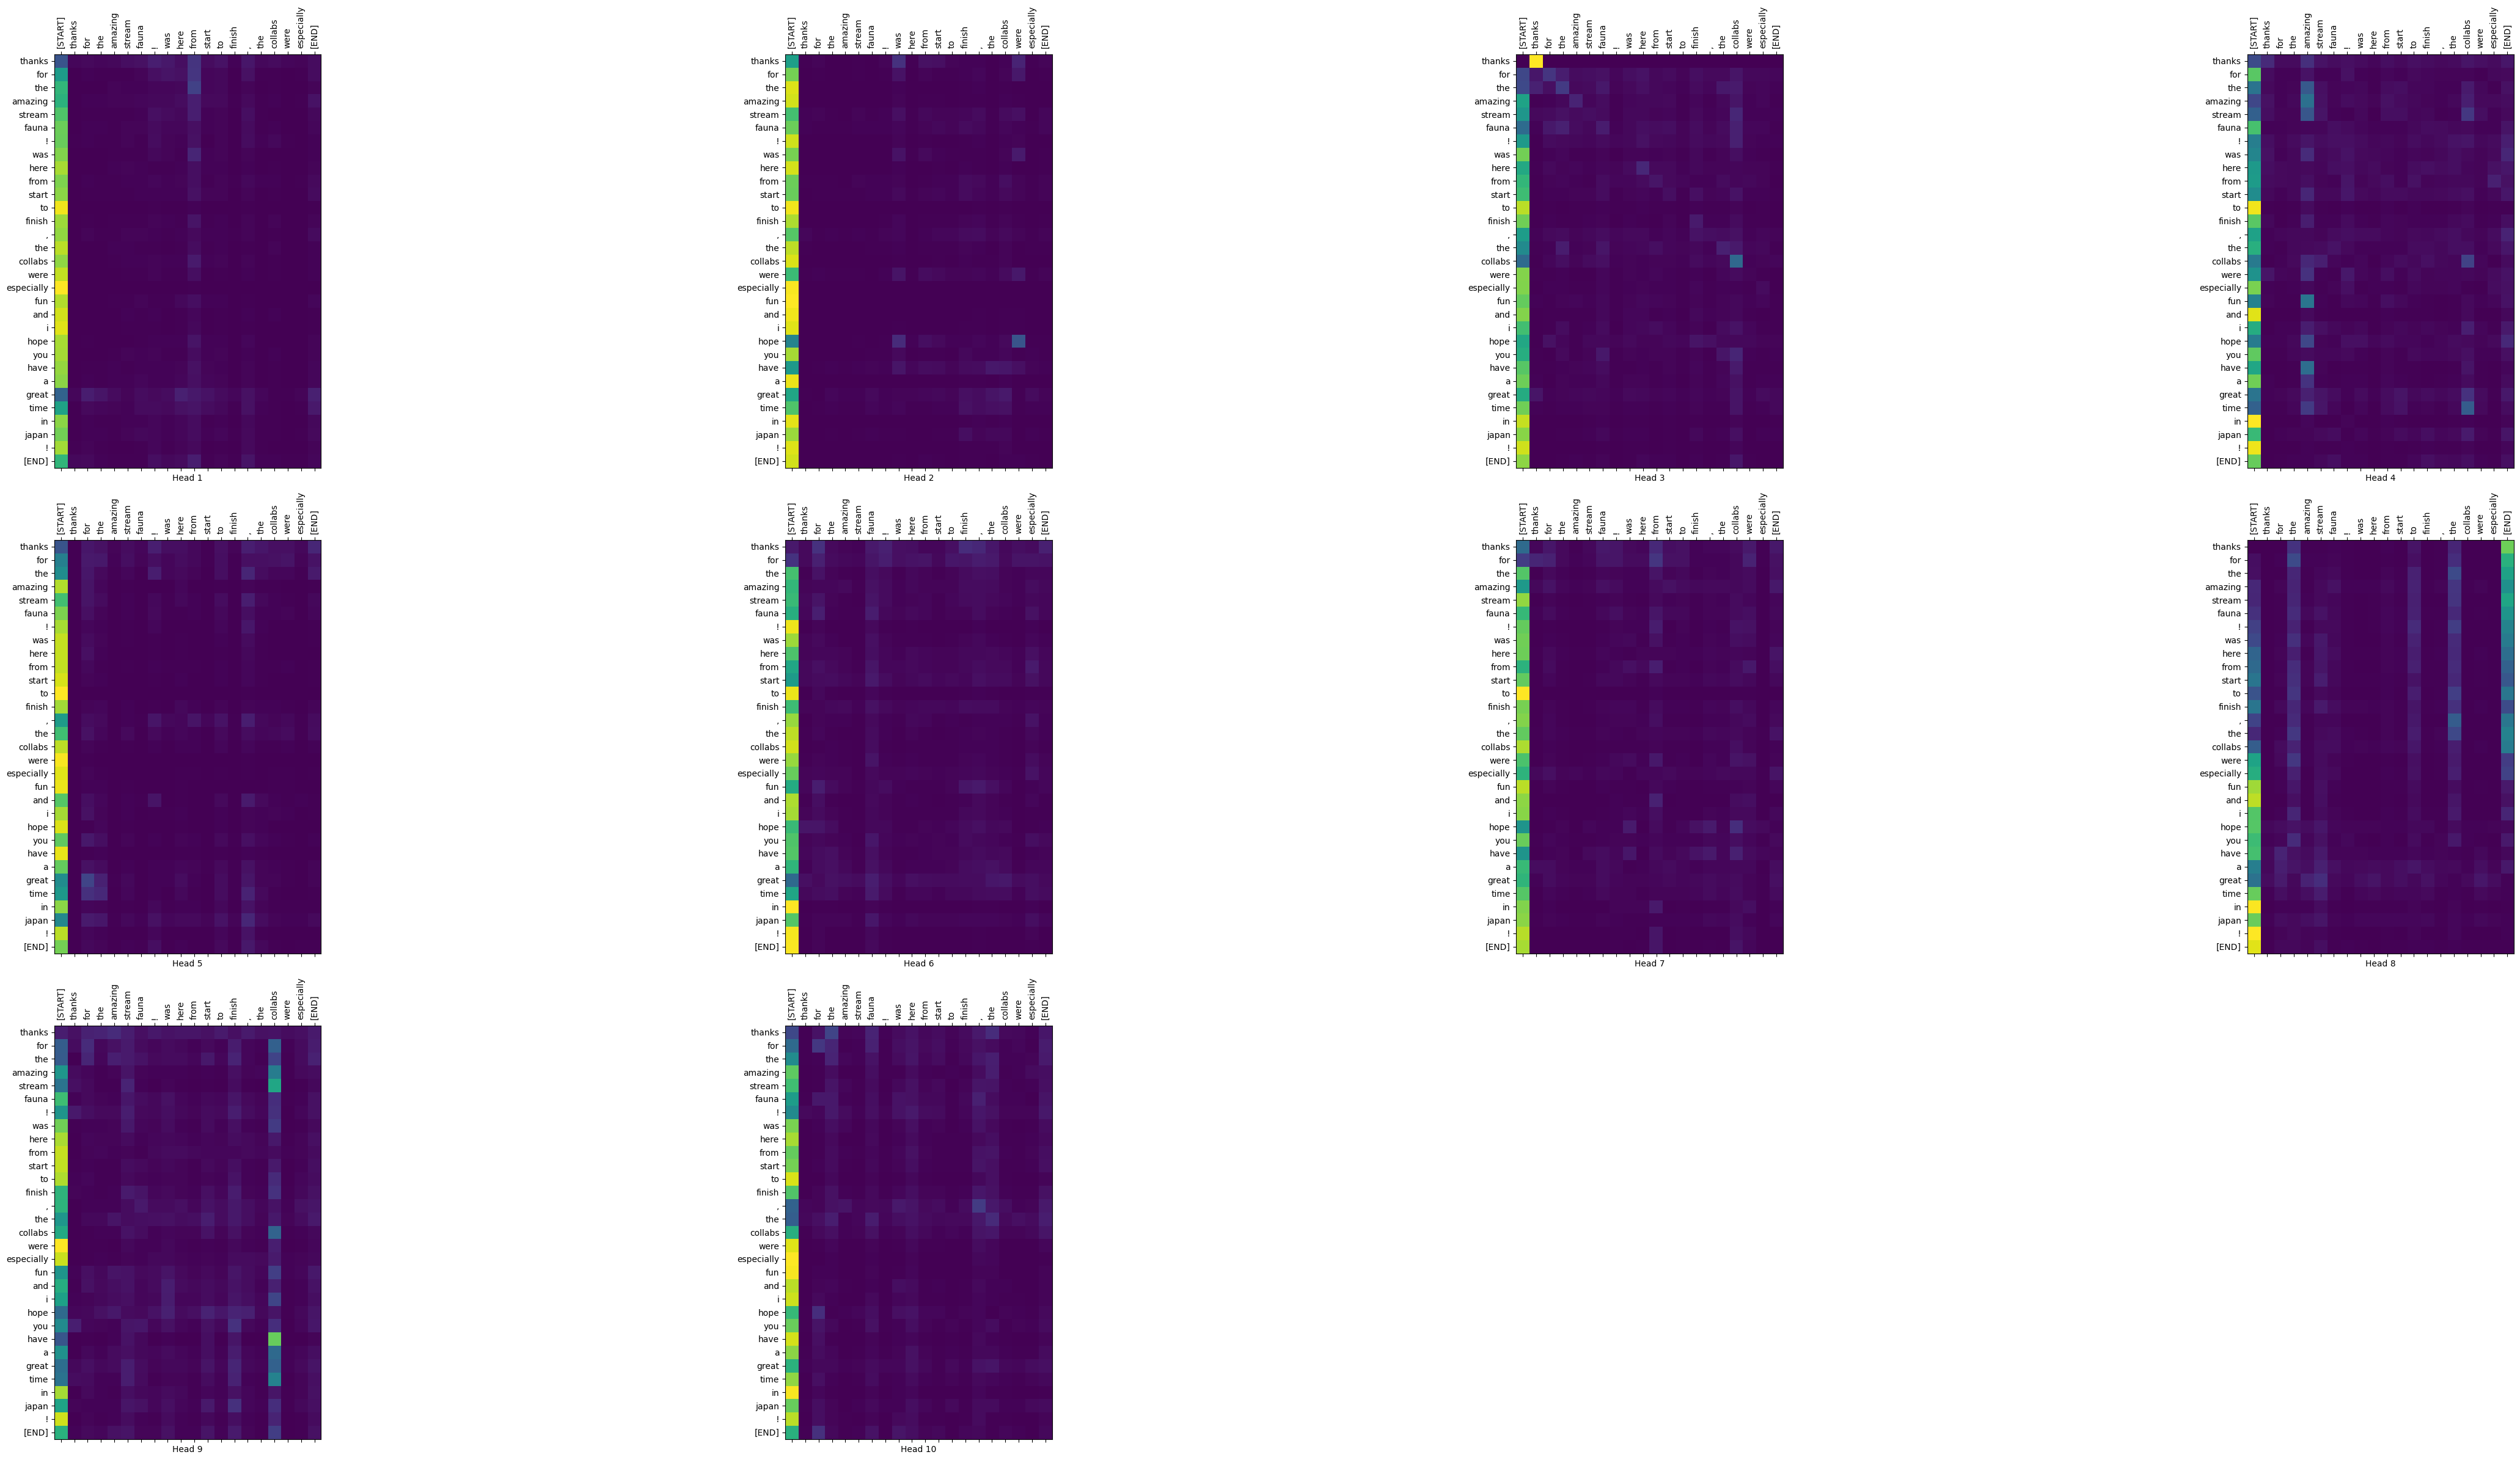

In [225]:
plot_attention_weights(sentence, output_tokens, attention_weights[0], start_focused = True)

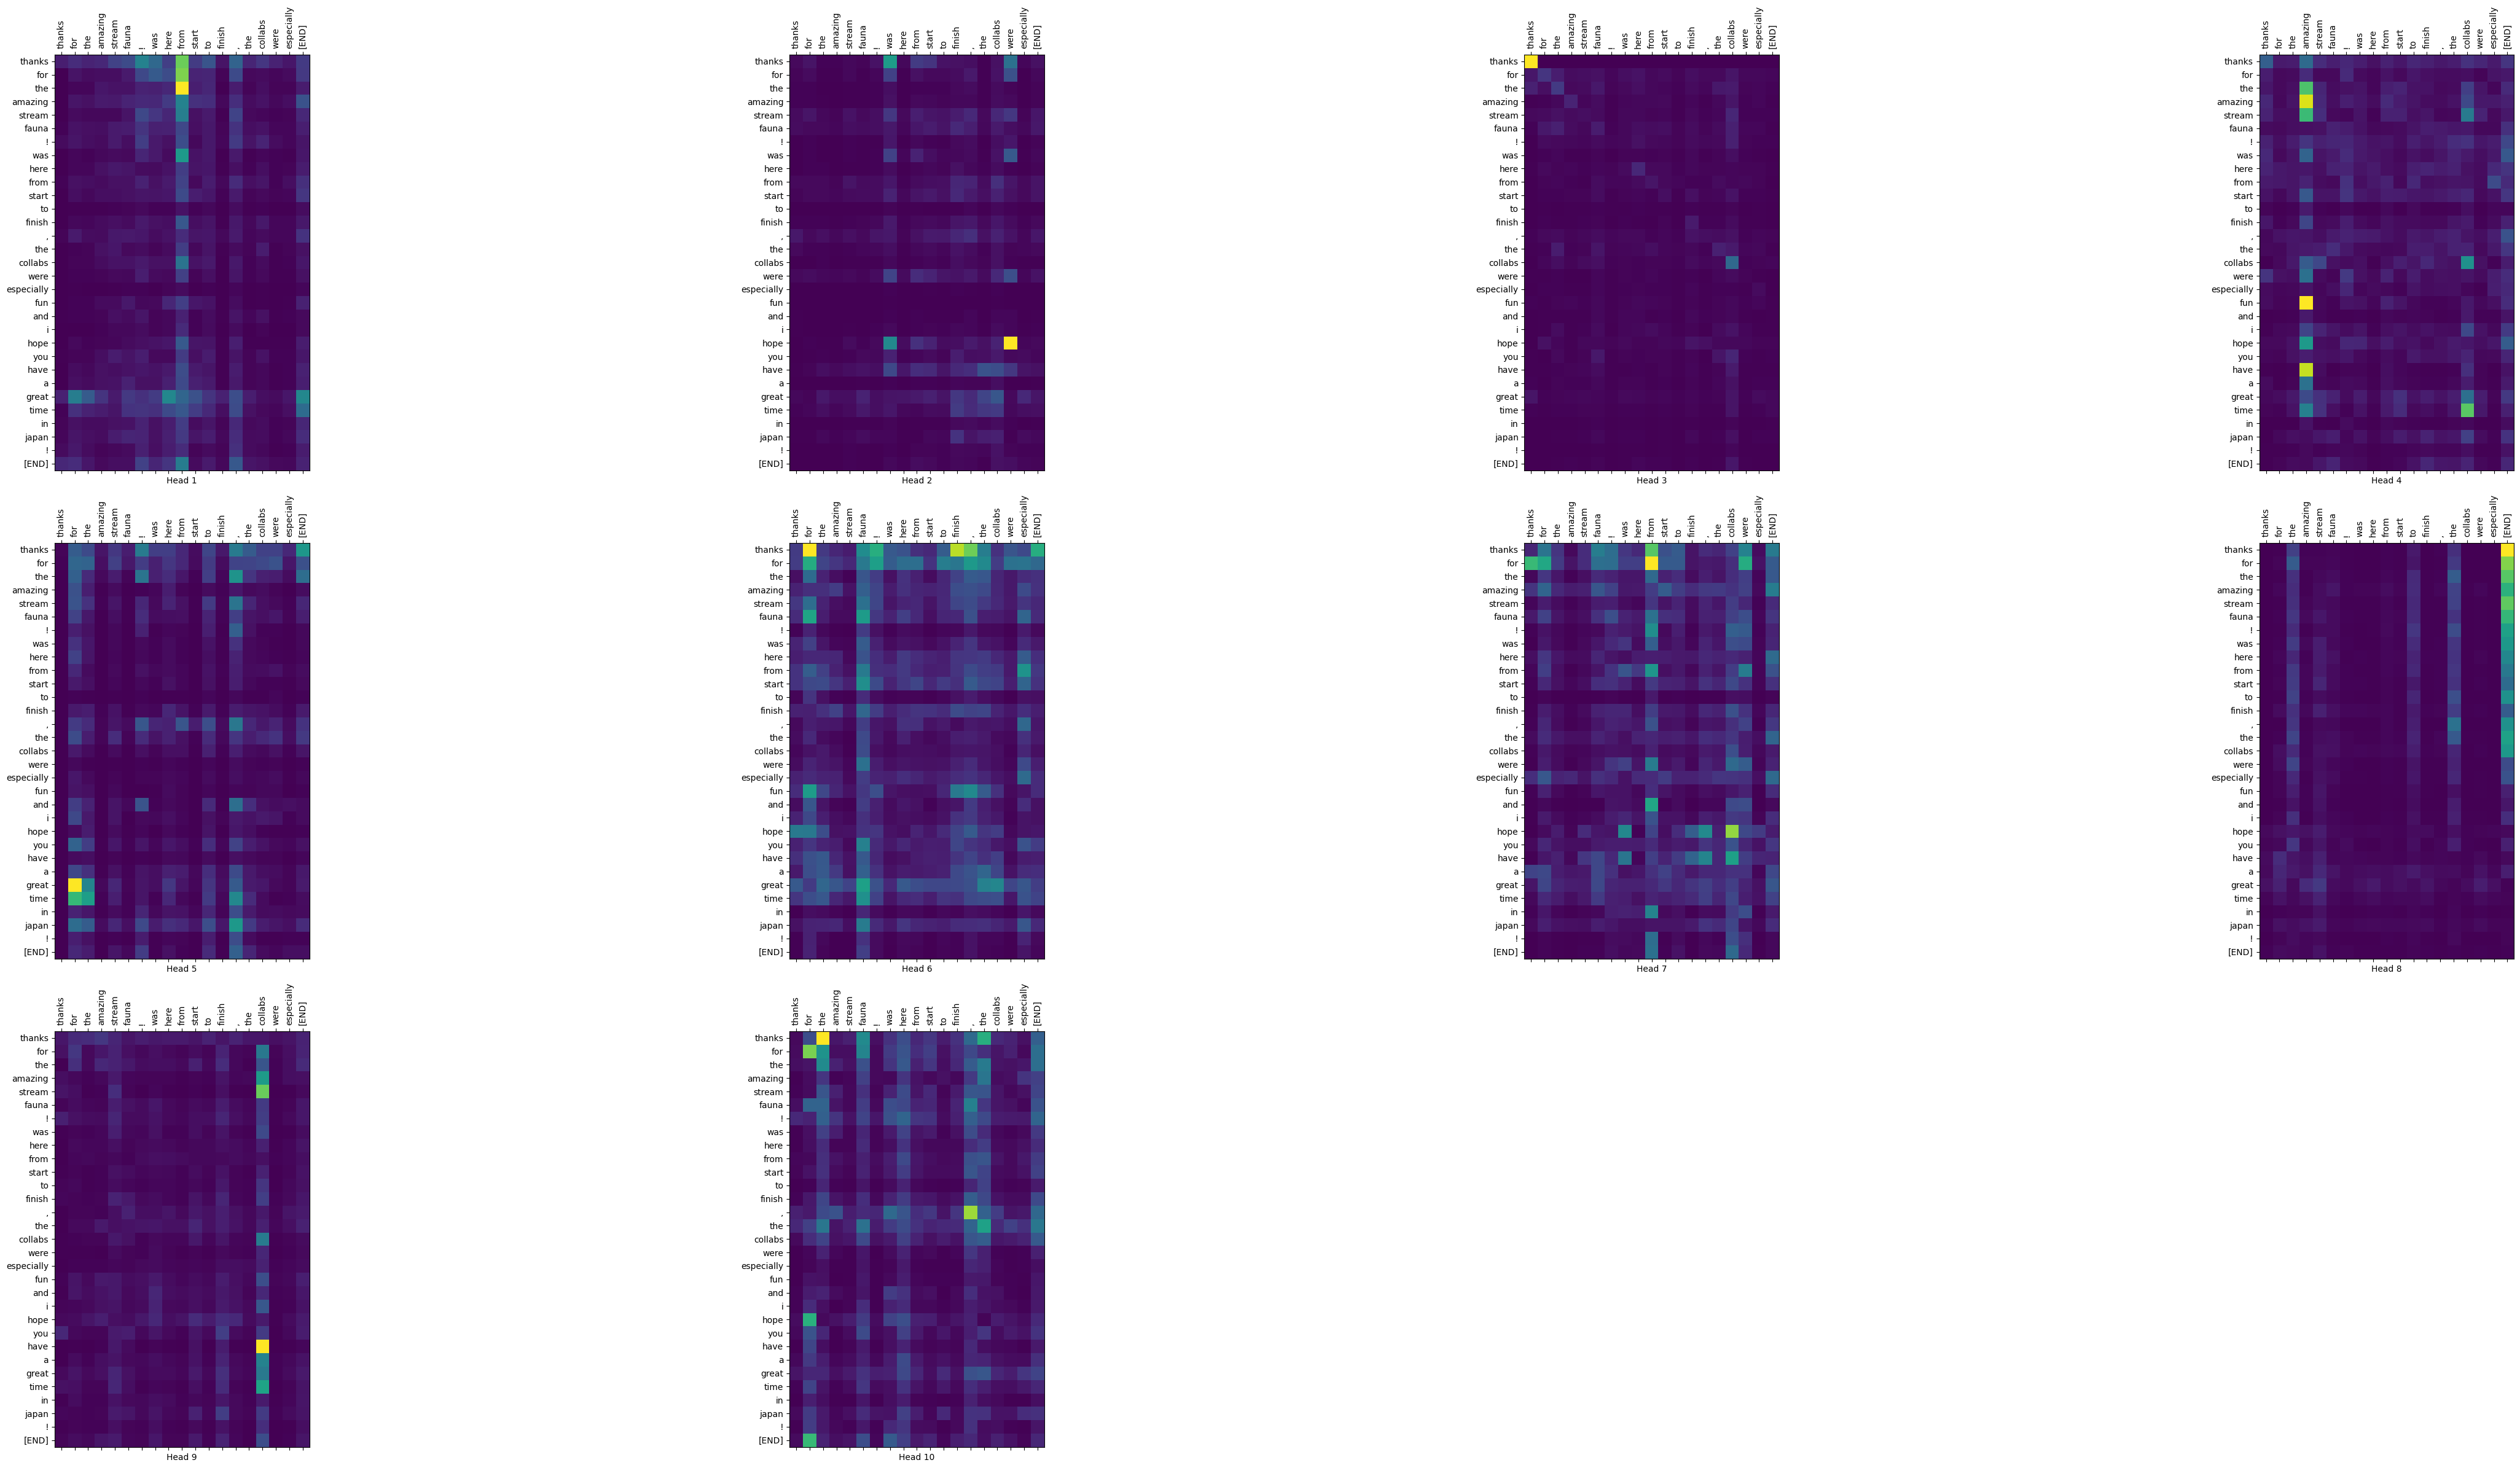

In [226]:
plot_attention_weights(sentence, output_tokens, attention_weights[0], start_focused = False)

# Export Model

In [ ]:
class ExportCommentator(tf.Module):
  def __init__(self, commentator):
    self.commentator = temperature_commentator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string),
                                tf.TensorSpec([], tf.float32)])
  def __call__(self, sentence, temperature=0):
    (result, tokens, attention_weights) = self.commentator(sentence = sentence, temperature = temperature, max_length=MAX_TOKENS)
    return result

In [ ]:
export_commentator = ExportCommentator(temperature_commentator)

In [ ]:
export_commentator('Give me')

<tf.Tensor: shape=(), dtype=string, numpy=b'give me a hug .'>

In [ ]:
tf.saved_model.save(export_commentator, export_dir = 'export_commentator3')

In [ ]:
reloaded_commentator = tf.saved_model.load(export_dir = 'export_commentator3')

In [ ]:
reloaded_commentator('Take care of')

<tf.Tensor: shape=(), dtype=string, numpy=b'take care of yourself , fauna !'>